In [1]:
from bs4 import BeautifulSoup
import requests
import regex as re
import pandas as pd
import os
import json
import random
import yfinance as yf

In [2]:
class Yahoo:
    def __init__(self, url : str = ''):
        self.url = url
        self.headers_list = [
                        'Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/59.0.3071.115 Safari/537.36',
                        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'
                        "Mozilla/5.0 (Windows NT 10.0; rv:91.0) Gecko/20100101 Firefox/91.0",
                        "Mozilla/5.0 (Windows NT 10.0; rv:78.0) Gecko/20100101 Firefox/78.0",
                        "Mozilla/5.0 (X11; Linux x86_64; rv:95.0) Gecko/20100101 Firefox/95.0",
                        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
                        'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
                        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
                        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
                        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36'
                        ] 
        self.soup = ""
        self.headers = {'User-Agent' : random.choice(self.headers_list) }

    def get_soup(self):
        r = requests.get(self.url, headers = self.headers, timeout=1000)
        self.soup = BeautifulSoup(r.content, "lxml")
        
        return self.soup
    
    def get_soupTextYahoo(self):
        if not self.soup:
            soup = self.get_soup()
        
        soupText = soup.find_all("div", {"class":"caas-body"})[0]
        
        return str(soupText.text)

class NBP(Yahoo):
    def __init__(self, url : str = ''):
        super().__init__(url) 
        self.soup = ""
        self.offertListLinks = []
        
    def make_offertListLinks(self):
        if not self.soup:
            soup = self.get_soup()
        
        classSoup = soup.find_all("div", {"class":"product-card"})
        for item in classSoup[:-1]:
            revenue_symbol = re.compile('(?<=href=")(.*?)(?=">)')
            link = re.findall(revenue_symbol, str(item))[0]
            link = f"https://www.obligacjeskarbowe.pl/{link}"
            self.offertListLinks.append(link)
        
        return self.offertListLinks
    
    def get_bondOffer(self, link):
        self.url = link
        soup = self.get_soup()
        
        labels = soup.find_all("strong", {"class":"product-details__list-label"})
        values = soup.find_all("span", {"class":"product-details__list-value"})
        
        offer = {}
        for i in range(len(labels)):
            valuePattern = '(?<=>\n                                    )(.*?)(?=\n)'
            val = re.findall(valuePattern, str(values[i]))[0]
            valNoSpace = val.replace(" ", "")
            if not val or not valNoSpace:
                val = str(values[i].text)
                val = val.replace("\n", "")
                val = val.split()
                val = ' '.join([str(elem) for elem in val])
                val = val.replace(" Zobacz tabelę odsetkową", "")
            
            label = str(labels[i].text).split()
            label = ' '.join([str(elem) for elem in label])
            label = label.replace(":","")
            
            offer[label] = val
        
                        
        return offer
        
    def get_nbpBondsDataframe(self):
        if not self.offertListLinks:
            self.offertListLinks = self.make_offertListLinks()
        
        dictList = []
        for link in self.offertListLinks:
            dictList.append(self.get_bondOffer(link))
            
        df = pd.DataFrame(dictList)
        return df


In [3]:
def show_news(stock_name= "MCD", time=None):
    news_data = yf.Ticker(stock_name).news
    filtered_news = [article for article in news_data if stock_name in article['relatedTickers']]


    news_info = []
    for news in filtered_news[-3:]:
        title = news['title']
        link = news['link']
        scrap = Yahoo(link)
        article = scrap.get_soupTextYahoo()
        news_info.append((title, link, article))

    return json.dumps(news_info), None



In [4]:
#scrap = Yahoo("https://finance.yahoo.com/news/yum-brands-yum-report-q3-155700403.html")

nbp = NBP("https://www.obligacjeskarbowe.pl/")
test = nbp.get_nbpBondsDataframe()

In [5]:
test

,Seria,Oprocentowanie,Kapitalizacja odsetek,Wypłata odsetek,Okres oprocentowania,Sprzedaż,Cena sprzedaży jednej obligacji,Cena zamiany jednej obligacji,Odsetki
0,OTS0224,"3,00% w skali roku, stałe przez cały 3-miesięc...",brak,przy wykupie obligacji,1.11.2023-01.02.2024,01.11.2023 - 30.11.2023,"100,00 zł","100,00 zł","0,76 zł"
1,ROR1124,"6,25% w skali roku, w pierwszym miesięcznym ok...",brak,co miesiąc,01.11.2023 - 01.12.2023,01.11.2023 - 30.11.2023,"100,00 zł","99,90 zł","Naliczane od wartości nominalnej, wypłacane po..."
2,DOR1125,"6,50% w skali roku, w pierwszym miesięcznym ok...",brak,co miesiąc,01.11.2023 - 01.12.2023,01.11.2023 - 30.11.2023,"100,00 zł","99,90 zł","Naliczane od wartości nominalnej, wypłacane po..."
3,TOS1126,"6,60%, stałe przez cały 3-letni okres oszczędz...",roczna,przy wykupie obligacji,01.11.2023 - 01.11.2026,01.11.2023 - 30.11.2023,"100,00 zł","99,90 zł","Naliczane od wartości nominalnej, kapitalizowa..."
4,COI1127,"6,75%, w kolejnych rocznych okresach odsetkowy...",brak,co roku,01.11.2023 - 01.11.2024,01.11.2023 - 30.11.2023,"100,00 zł","99,90 zł","Naliczane od wartości nominalnej, wypłacane po..."
5,EDO1133,"7,00% w pierwszym rocznym okresie odsetkowym, ...",roczna,przy wykupie obligacji,01.11.2023 - 01.11.2024,01.11.2023 - 30.11.2023,"100,00 zł","99,90 zł","Naliczane od wartości nominalnej, kapitalizowa..."
6,ROS1129,"6,95% w pierwszym rocznym okresie odsetkowym, ...",roczna,przy wykupie obligacji,01.11.2023 - 01.11.2024,01.11.2023 - 30.11.2023,"100,00 zł",NaN,"Naliczane od wartości nominalnej, kapitalizowa..."
7,ROD1135,"7,25% w pierwszym rocznym okresie odsetkowym, ...",roczna,przy wykupie obligacji,01.11.2023 - 01.11.2024,01.11.2023 - 30.11.2023,"100,00 zł",NaN,"Naliczane od wartości nominalnej, kapitalizowa..."


https://otomotodata.blob.core.windows.net/charts/chart_lukasz1699544511.png


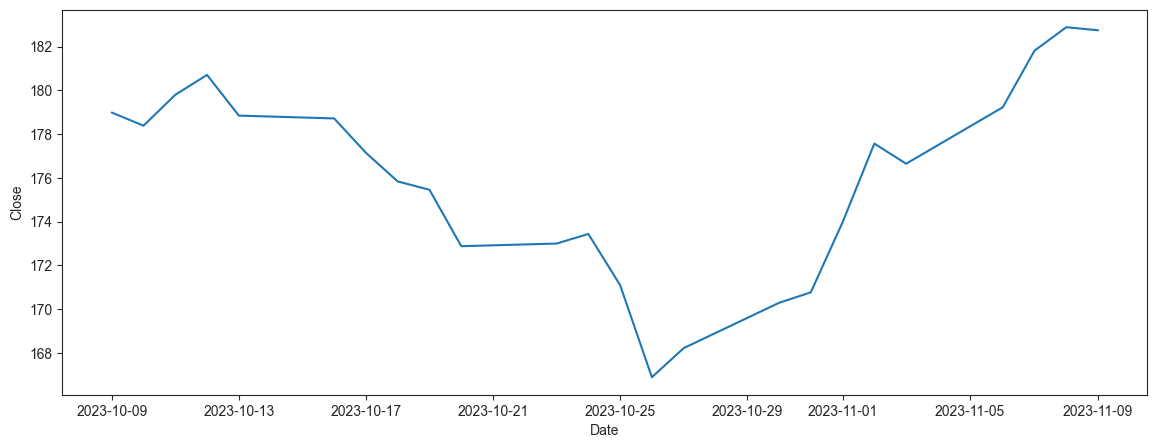

In [14]:
from azure.storage.blob import BlobServiceClient
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot
import yfinance as yf
import time
import os


def uploadChartToBlobStorage(fig, user):
    connect_str = "DefaultEndpointsProtocol=https;AccountName=otomotodata;AccountKey=FQ+vB6P/bdgHh2m2hmYLPqWDywq16SjAjhVfIwGrelZYrhT/ugs2ozrMotb0M6vAl94N/fG67MUZ+AStEMHcsg==;EndpointSuffix=core.windows.net"
    container_name = "charts"
    blob_service_client = BlobServiceClient.from_connection_string(connect_str)
    blobName = f"chart_{user}{round(time.time())}.png"
    fig.figure.savefig(blobName)
    
    blob_client = blob_service_client.get_blob_client(container=container_name, blob = blobName)
    with open(file=blobName, mode="rb") as data:
        blob_client.upload_blob(data)

    os.remove(blobName)
    
    return blob_client.url

stock_data = yf.Ticker("AAPL").history(period="1mo")
plt.figure(figsize=(14,5))
fig = sns.lineplot(data=stock_data,x="Date",y='Close')

print(uploadChartToBlobStorage(fig, "lukasz"))
#https://otomotodata.blob.core.windows.net/charts/chart_lukasz1699542485.html

In [24]:
jsooon =[
  {
    "response": "Hello qq! I'm here to help you maximize your investment returns. How can I assist you today?",
    "promt": "Say short hello to user",
    "url": "null"
  },
  {
    "promt": "aaa",
    "response": "I apologize if I don't understand what you meant by \"aaa\". Could you please provide more details or let me know how I can assist you?",
    "url": "null"
  },
  {
    "promt": "jest",
    "response": "Ah, I see. Well, if you have any financial questions or if there's anything I can assist you with regarding investment strategies or maximizing returns, please feel free to ask!",
    "url": "null"
  },
  {
    "promt": "ok",
    "response": "Great! Please don't hesitate to reach out if you have any questions or need any assistance. I'm here to help you make informed financial decisions and maximize your investment returns.",
    "url": "null"
  }
]

In [25]:
print(jsooon)

[{'response': "Hello qq! I'm here to help you maximize your investment returns. How can I assist you today?", 'promt': 'Say short hello to user', 'url': 'null'}, {'promt': 'aaa', 'response': 'I apologize if I don\'t understand what you meant by "aaa". Could you please provide more details or let me know how I can assist you?', 'url': 'null'}, {'promt': 'jest', 'response': "Ah, I see. Well, if you have any financial questions or if there's anything I can assist you with regarding investment strategies or maximizing returns, please feel free to ask!", 'url': 'null'}, {'promt': 'ok', 'response': "Great! Please don't hesitate to reach out if you have any questions or need any assistance. I'm here to help you make informed financial decisions and maximize your investment returns.", 'url': 'null'}]


In [28]:
def converJSONToMesseges(jsooon):
    messeges = []
    for item in jsooon:
        rowAssistant = {"role" : "assistant", "content" : item["response"]}
        rowUser = {"role" : "assistant", "content" : item["promt"]}
        
        messeges.append(rowAssistant)
        messeges.append(rowUser)
            
    return messeges

converJSONToMesseges(jsooon)

[{'role': 'assistant',
  'content': "Hello qq! I'm here to help you maximize your investment returns. How can I assist you today?"},
 {'role': 'assistant', 'content': 'Say short hello to user'},
 {'role': 'assistant',
  'content': 'I apologize if I don\'t understand what you meant by "aaa". Could you please provide more details or let me know how I can assist you?'},
 {'role': 'assistant', 'content': 'aaa'},
 {'role': 'assistant',
  'content': "Ah, I see. Well, if you have any financial questions or if there's anything I can assist you with regarding investment strategies or maximizing returns, please feel free to ask!"},
 {'role': 'assistant', 'content': 'jest'},
 {'role': 'assistant',
  'content': "Great! Please don't hesitate to reach out if you have any questions or need any assistance. I'm here to help you make informed financial decisions and maximize your investment returns."},
 {'role': 'assistant', 'content': 'ok'}]